# **DOMAIN´S CLUSTERING**

- In this notebook I´m going to try and test different clustering models, preprocessing the data in different ways to compare and choose the best results, that is, to find different clusters with similar charasteristics or properties, with the objective of make the advertiser decision of where are the optimal domains to invest easier

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

#! pip install pyclustertend

In [106]:
minmax.shape

(818, 7)

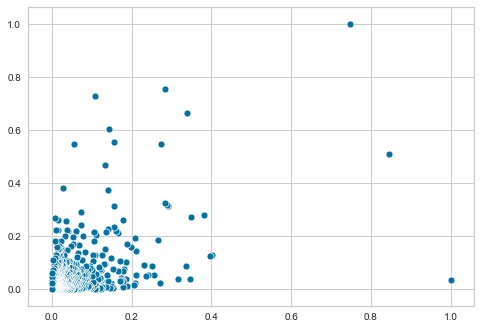

In [107]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)
sns.scatterplot(minmax[:,0],minmax[:,1])


In [5]:
groupby_domains = pd.read_csv('Global groupby_domains.csv')

I´m gonna test the clustering over two different data transformations :

- **Standarizing the data with Standard Scaler**
- **Scaling features using statistics that are robust to outliers with Robust Scaler**

****In order to get a better clustering performance, I´m gonna drop the following columns :****

- **Domain:** it´s a string and doesn´t add nothing to the model
- **Category:** I could convert the Categories into numbers, but this can strongly affect to the model, and the categories are also represented in the Category importance columns
- **Viewability Rate, Efficiency Rate:** these columns are important to the advertisers (that´s the reason I didn´t drop them in the first place) but both of them have really high percentages for most of Domains, so they are not useful to find differences between them

In [6]:
groupby_domains_clustering = groupby_domains.drop(['Domain','Format Fill Rate', 'Clicks','Category',
                                                   'Viewability Rate', 'Efficiency Rate'], 1)
groupby_domains_StandardScaler = StandardScaler().fit_transform(groupby_domains_clustering)
groupby_domains_RobustScaler = RobustScaler().fit_transform(groupby_domains_clustering)

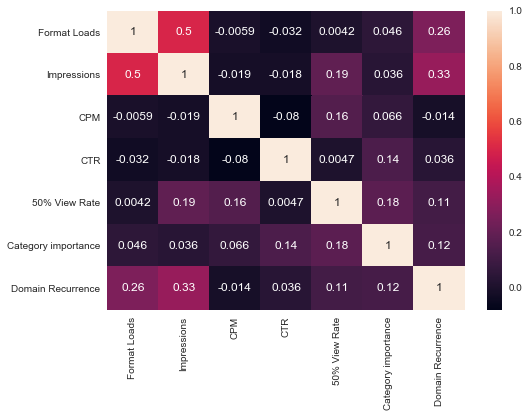

In [7]:
sns.heatmap(groupby_domains_clustering.corr(), annot=True)

In [12]:
pca = PCA()
pca.fit_transform(groupby_domains_RobustScaler)

array([[19.98199273,  1.51503912, 14.93108911, ..., -2.33902676,
         0.11549493,  0.86854918],
       [22.06576359,  0.2950571 ,  5.94970418, ..., -1.81524825,
         0.46366262, -0.55544298],
       [25.65826143, -0.05842712, -3.39825385, ..., -2.94529227,
         1.67767096, -0.51379258],
       ...,
       [-1.37484404,  0.40278012, -0.170579  , ..., -0.09572742,
         1.36024366, -0.37068073],
       [-1.32548885,  9.27023819, -0.7851011 , ..., -0.93029318,
        -0.4034716 ,  0.23771051],
       [-0.91101246,  0.03628961, -0.85328359, ..., -0.49025558,
         1.0156338 , -0.37922025]])

Text(0, 0.5, 'Cumulative explained variance')

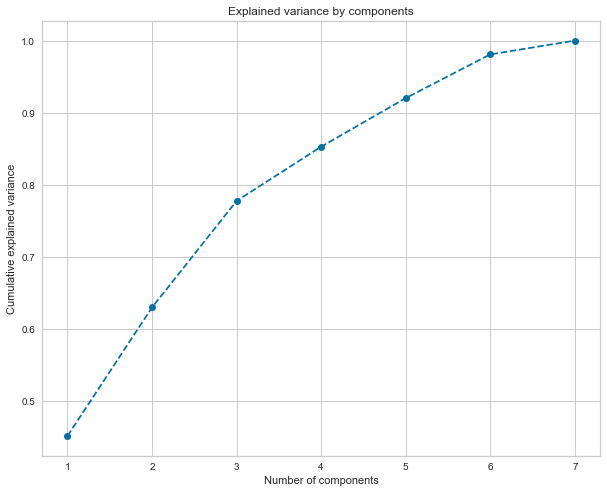

In [13]:
plt.figure(figsize=(10,8))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

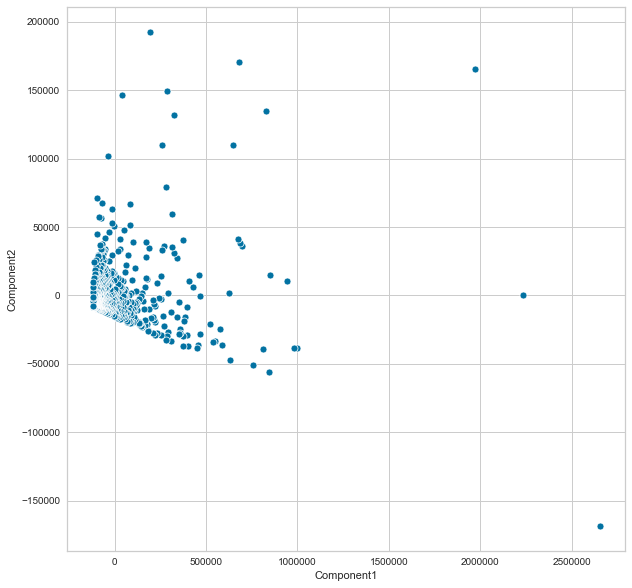

In [19]:
pca = PCA(n_components=2)
groupby_domains_clustering_pca = pca.fit_transform(groupby_domains_clustering)
groupby_domains_clustering_pca = pd.DataFrame(groupby_domains_clustering_pca, columns=['Component1', 'Component2'])
plt.figure(figsize = (10,10))
sns.scatterplot(groupby_domains_clustering_pca['Component1'], groupby_domains_clustering_pca['Component2'])

## Applying GRIDSEARCHCV to find the best parameters for KMEANS ALGORITHM

- ### With the Standard Scaler transformation:

In [8]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,15),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_standardscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [10]:
%%time
gridsearchcv_standardscaler.fit(groupby_domains_StandardScaler)

Wall time: 42min 47s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 500, 700, 1000],
                         'n_clusters': range(1, 15),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#Saving the results in a DataFrame
gridsearch_results_SS = pd.DataFrame(gridsearchcv_standardscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_SS.to_csv('GridSearch Standard Scaler Results.csv')
gridsearch_results_SS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3145,0.04,0.00,0.00,0.00,elkan,random,400,14,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-1817.66,-527.36,-547.53,-402.67,-441.44,-747.33,537.82,1
1815,0.08,0.01,0.00,0.00,full,random,100,14,5,"{'algorithm': 'full', 'init': 'random', 'max_i...",-2077.53,-493.75,-527.52,-408.41,-485.67,-798.58,640.67,2
3146,0.10,0.00,0.00,0.00,elkan,random,400,14,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-2102.65,-454.43,-534.86,-390.99,-510.29,-798.64,653.88,3


In [13]:
# save the model to disk
filename = 'gridsearchmodel_standardscaler.sav'
pickle.dump(gridsearchcv_standardscaler, open(filename, 'wb'))

In [14]:
# load the model from disk
filename = 'gridsearchmodel_standardscaler.sav'
gridsearchmodel_standardscaler = pickle.load(open(filename, 'rb'))


In [15]:
gridsearchmodel_standardscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=400,
       n_clusters=14, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the Robust Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_robustscaler.fit(groupby_domains_RobustScaler)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_RS = pd.DataFrame(gridsearchcv_robustscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_RS.to_csv('GridSearch Results with Robust Scaler.csv')
gridsearch_results_RS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**I decide not to choose the random init, although it has been chosen as the best init parameter in both scenarios. In some cases, if the initialization of clusters is not appropriate, K-Means can result in arbitrarily bad clusters. This is where K-Means++ helps, because it specifies a procedure to initialize the cluster centers before moving forward with the standard k-means clustering algorithm**

**Using the K-Means++ algorithm, we optimize the step where we randomly pick the cluster centroid, and we are more likely to find a solution that is competitive to the optimal K-Means solution while using the K-Means++ initialization**

Because of that, I´ll choose the best result where with the k-means++ init:

In [19]:
gridsearch_results_RS = pd.read_csv("GridSearch Results with Robust Scaler.csv")
gridsearch_results_SS = pd.read_csv("GridSearch Standard Scaler Results.csv")
display(gridsearch_results_RS[gridsearch_results_RS['param_init']=='k-means++'].head(1))
display(gridsearch_results_RS[gridsearch_results_SS['param_init']=='k-means++'].head(1))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,556,0.16,0.01,0.00,0.00,auto,k-means++,1000,16,10,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",-5363.48,-682.62,-667.99,-592.56,-580.18,-1577.37,1893.49,10


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3350,0.06,0.00,0.00,0.00,elkan,random,1000,15,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5381.67,-690.97,-703.62,-508.84,-577.82,-1572.59,1905.92,8


## ELBOW METHOD visualization to check the ideal number of clusters 

- ### With the Standard Scaler transformation:

In [45]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

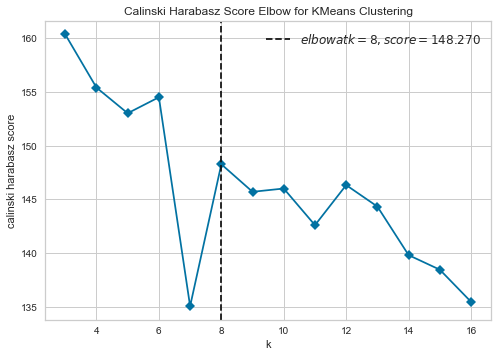

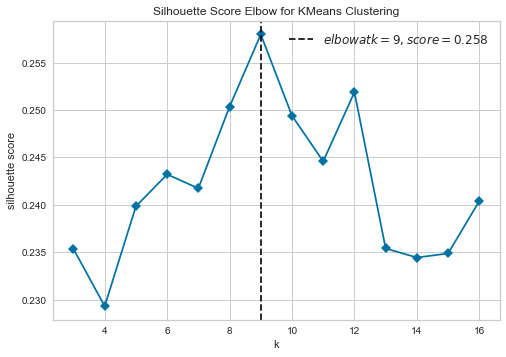

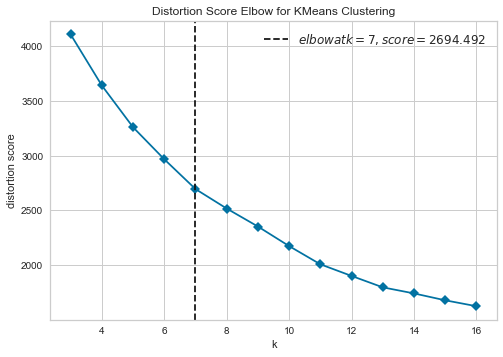

In [50]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the Robust Scaler transformation:

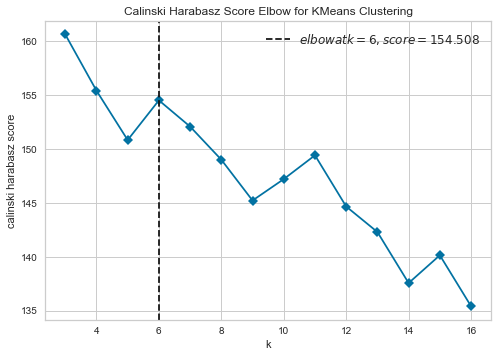

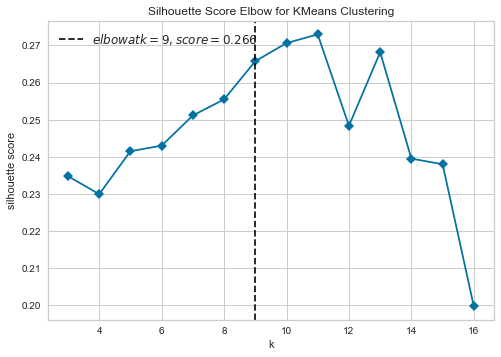

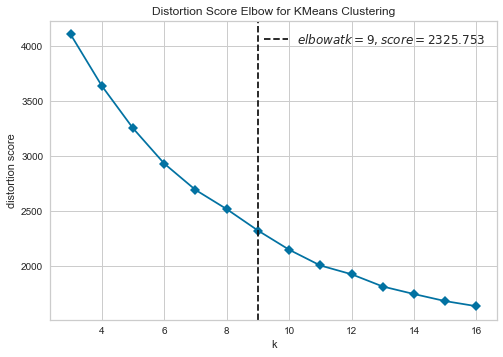

In [51]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the MinMax transformation:

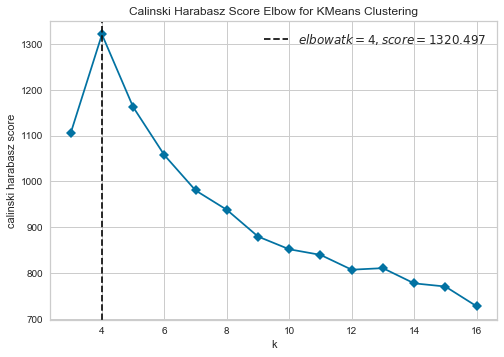

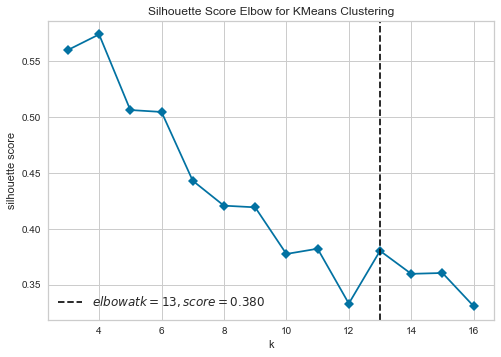

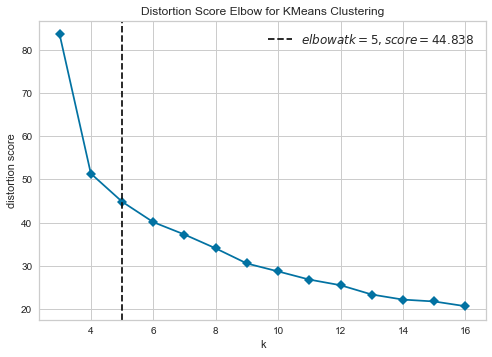

In [112]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(minmax, model)

- **My first impression is that, in order to simplify and make the advertiser decision easier, detecting a specific cluster attending to its preferences, the number of clusters should not be more than 10**

- **The GridSearchCV best result for n_clusters is the maximum I defined (14 in the first case, and 16 in the second case). But attending to the Elbow Method I´m gonna train the Kmeans Model with 9 clusters**

## Training the KMEANS model

In [190]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))


- ### With the optimal parameters for Standard Scaled Data, based on the GridSearchCV results

In [191]:
kmeans_StandardScaler = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_StandardScaler.fit(groupby_domains_StandardScaler)
results_evaluation(kmeans_StandardScaler, groupby_domains_StandardScaler)


CLUSTERING DIVISION:
 2    242
1    180
0    126
8     85
3     78
4     52
7     26
5     20
6      9
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,256329.73,17791.20,9.09,84.74,97.16,1.69,133.05,0.75,75.58,0.59,2.17
1,139822.54,10631.49,9.18,84.45,96.53,1.66,59.55,0.49,76.63,0.04,0.09
2,146618.29,10951.79,8.59,85.64,97.57,1.69,67.99,0.61,75.79,0.59,0.24
3,154853.04,4863.34,4.17,75.16,94.01,1.72,32.36,0.61,53.33,0.09,0.21
4,137299.89,8600.61,7.12,88.54,97.07,1.60,171.44,2.00,71.69,0.46,0.27
5,1012097.92,133162.21,24.17,83.04,98.31,1.68,758.45,0.57,77.46,0.34,2.05
6,114131.67,1296.13,1.74,40.48,38.71,0.41,6.67,0.11,30.40,0.09,0.00
7,144306.98,7575.87,5.84,82.01,97.01,2.49,19.11,0.38,71.74,0.40,0.04
8,221147.62,23883.21,13.20,82.09,97.79,1.66,138.37,0.66,74.92,0.05,1.96


The Silhouette Score is:  0.2547871920561031
The Calinski Harabasz Score is:  147.73997657197066


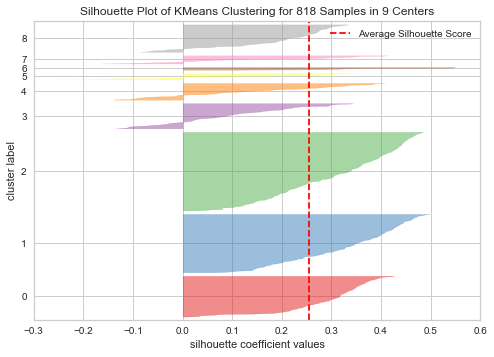

In [193]:
sv = SilhouetteVisualizer(kmeans_StandardScaler)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the optimal parameters for Robust Scaled Data, based on the GridSearchCV results

In [194]:
kmeans_RobustScaler = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_RobustScaler.fit(groupby_domains_RobustScaler)
results_evaluation(kmeans_RobustScaler, groupby_domains_RobustScaler)


CLUSTERING DIVISION:
 7    373
3    183
5    120
0     49
1     44
2     27
8     10
4      9
6      3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,675924.77,31547.97,5.23,82.78,96.56,1.67,229.51,0.71,71.73,0.39,1.16
1,205884.58,55816.35,34.89,84.24,98.90,1.68,264.24,0.52,80.78,0.33,0.95
2,156042.66,3280.92,2.84,81.23,96.91,2.47,21.67,0.41,70.66,0.36,0.11
3,194215.47,14898.66,9.14,84.18,97.40,1.67,112.36,0.76,74.95,0.40,2.08
4,574870.75,175301.57,38.72,81.46,99.46,1.71,1121.49,0.63,79.44,0.34,2.78
5,130797.55,4565.75,4.19,78.50,94.64,1.71,36.68,0.81,57.13,0.21,0.19
6,2473559.25,154454.72,7.57,83.18,96.59,1.64,484.58,0.34,71.62,0.40,1.00
7,119640.94,8350.90,7.81,85.76,97.19,1.67,61.13,0.66,77.17,0.34,0.14
8,113392.25,1355.62,1.80,45.37,44.25,0.46,9.20,0.25,33.80,0.14,0.00


The Silhouette Score is:  0.22185911385236418
The Calinski Harabasz Score is:  203.093127296526


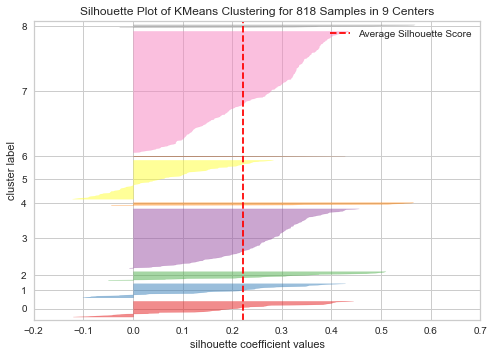

In [195]:
sv = SilhouetteVisualizer(kmeans_RobustScaler)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the MinMax transformation

In [196]:
kmeans_minmax = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_minmax.fit(minmax)
results_evaluation(kmeans_minmax, minmax)


CLUSTERING DIVISION:
 3    221
8    199
6     89
7     75
4     75
1     49
0     43
2     38
5     29
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,123220.07,8052.24,7.49,89.55,97.97,1.62,153.87,1.79,72.53,0.59,0.00
1,251106.47,21990.44,13.00,83.91,97.43,1.65,117.42,0.61,72.73,0.04,1.00
2,406972.88,49323.14,12.91,83.44,97.62,1.72,357.36,0.72,75.90,0.59,3.00
3,148086.75,9934.78,8.23,83.69,96.06,1.70,63.09,0.62,73.45,0.04,0.00
4,261934.27,19666.20,8.59,83.71,96.86,1.70,130.07,0.73,73.30,0.59,1.00
5,148971.35,3096.95,2.76,57.31,79.60,1.49,12.93,0.30,37.71,0.04,0.00
6,208608.98,16204.05,9.71,85.24,97.31,1.67,129.00,0.78,75.66,0.59,2.00
7,239255.45,26643.88,11.93,80.89,97.67,1.67,136.48,0.66,73.99,0.04,2.27
8,149314.64,10227.87,8.01,85.34,96.87,1.73,55.90,0.53,75.02,0.59,0.00


The Silhouette Score is:  0.4241273963992878
The Calinski Harabasz Score is:  896.0823896544617


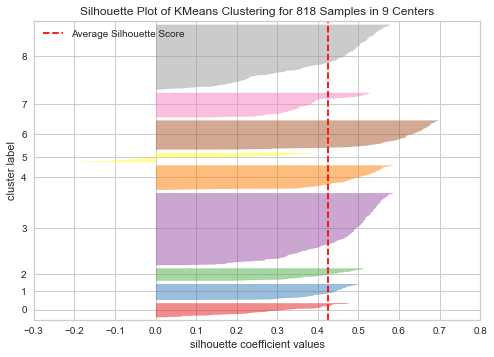

In [197]:
sv = SilhouetteVisualizer(kmeans_minmax)
sv.fit(minmax)
sv.show()

- ### Conclusions:

K-means doesn´t seem to be a good model for this data. The main reasons are:

- In a range bewteen -1 and 1, if the Silhouette Score is close to one, that means clusters are dense and well separated, which relates to a standard concept of a cluster. In both cases the Silhouette Score is around 0.20. And in the Silhouette Score analysis, we can confirm that we only have a decent score when the number of clusters is 2

- It´s visually difficult to diferenciate the clusters in the graph

- K-Means doesn´t use to work well with large datasets and many features, and it has proven that the eucledian distance metric can be a wrong metric with high dimensions

- Ouliers is clearly a problem in this dataset and Kmeans algorithm is really sensitive to this ouliers, although I´ve applied the Robust Scaler transformation, which minimizes the impact of the outliers 

- According to the evalution metrics (Silhouette Score and Calinski-Harabasz Index) there´s not a big difference between using the data with the Standard Scaler transformation, or the Robust Scaler transformation, but the results highly improved using the MinMaxScaler






## HIERARCHICAL CLUSTERING

In [118]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


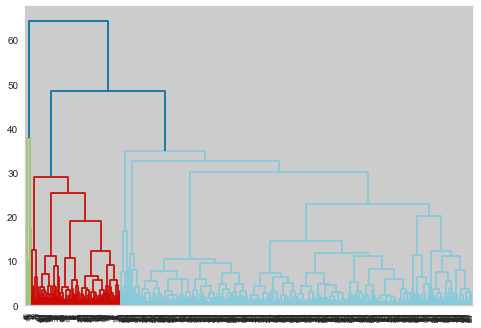

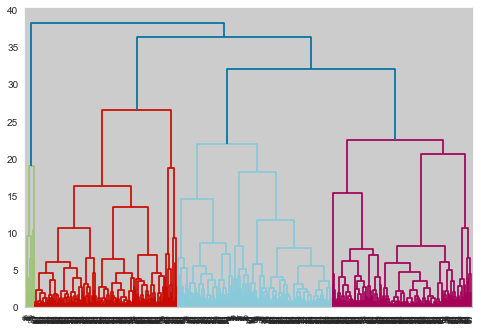

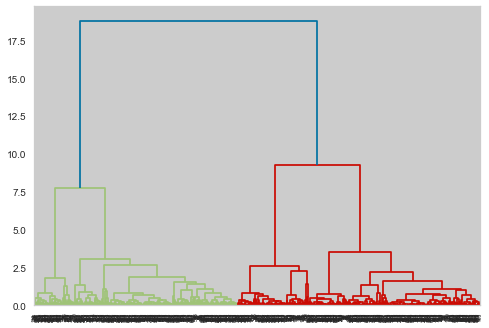

In [119]:
for data in [groupby_domains_RobustScaler,groupby_domains_StandardScaler,minmax]:
    Z = linkage(data, 'ward') #'single', 'ward', ...
    dendrogram(Z)
    plt.show()

- ### ROBUSTSCALER transformation

In [148]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_RobustScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32),
 array([  8,   3,  14,  37, 112,  16,  21, 197, 300,  34,  76], dtype=int64))

In [198]:
cluster = AgglomerativeClustering(n_clusters=11)  
cluster.fit(groupby_domains_RobustScaler)
results_evaluation(cluster, groupby_domains_RobustScaler)

CLUSTERING DIVISION:
 9     300
6     197
0     112
2      76
8      37
10     34
5      21
4      16
3      14
7       8
1       3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,375445.12,14845.39,4.89,81.97,96.50,1.69,92.32,0.61,72.85,0.38,1.09
1,2473559.25,154454.72,7.57,83.18,96.59,1.64,484.58,0.34,71.62,0.40,1.00
2,107825.14,4197.75,4.09,76.08,95.21,1.81,21.64,0.47,57.27,0.14,0.08
3,943782.52,44894.13,5.68,81.55,95.39,1.65,292.56,0.60,71.21,0.28,0.86
4,115055.30,1388.35,1.67,57.08,57.86,0.74,10.00,0.28,46.32,0.20,0.00
5,127714.26,3633.34,3.36,82.97,97.03,2.54,22.23,0.39,72.88,0.35,0.00
6,152769.52,12350.21,8.93,84.61,97.21,1.68,98.69,0.79,74.15,0.41,1.82
7,588591.20,183238.45,40.36,81.95,99.45,1.71,1216.82,0.66,79.89,0.31,2.75
8,281222.85,64726.76,33.25,83.35,98.68,1.69,330.11,0.54,78.53,0.32,1.19


The Silhouette Score is:  0.18872780992980265
The Calinski Harabasz Score is:  171.57169700011974


- ### STANDARDSCALER transformation

In [144]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_StandardScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 17, 239,  23, 103, 181,  92, 136,  27], dtype=int64))

In [199]:
cluster = AgglomerativeClustering(n_clusters=8)  
cluster.fit(groupby_domains_StandardScaler)
results_evaluation(cluster, groupby_domains_StandardScaler)

CLUSTERING DIVISION:
 4    239
1    181
7    136
6    103
5     92
3     27
2     23
0     17
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,1000553.51,146605.49,27.48,81.65,98.76,1.69,829.46,0.55,77.75,0.39,2.35
1,268486.27,17001.88,8.75,84.34,97.08,1.69,118.25,0.68,75.28,0.57,1.73
2,129641.78,1429.87,1.40,49.52,68.40,1.26,4.14,0.13,30.77,0.22,0.04
3,153942.77,4695.30,3.88,85.32,97.31,2.41,26.09,0.43,74.05,0.46,0.00
4,130092.28,8114.12,7.39,83.12,96.31,1.68,54.33,0.63,71.59,0.04,0.11
5,137192.96,8729.37,7.24,89.02,97.33,1.66,135.72,1.52,73.13,0.57,0.30
6,215743.56,27033.49,15.92,82.63,97.80,1.67,136.10,0.56,75.34,0.07,1.73
7,127242.64,9397.78,7.98,84.88,97.53,1.66,51.99,0.48,76.10,0.59,0.00


The Silhouette Score is:  0.2008839817882763
The Calinski Harabasz Score is:  125.24302251524875


- ### MINMAX transformation

In [122]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 2.5
clusters_hc = fcluster(linkage(minmax, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 75,  49,  13, 237,  89,  40,  72, 243], dtype=int64))

In [200]:
cluster = AgglomerativeClustering(n_clusters=8)  
cluster.fit(minmax)
results_evaluation(cluster, minmax)

CLUSTERING DIVISION:
 1    243
2    237
7     89
3     75
4     72
5     49
0     40
6     13
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,500893.83,58203.16,12.81,83.41,97.69,1.71,374.61,0.70,75.81,0.59,2.90
1,144632.16,9809.73,7.89,85.91,97.07,1.71,73.01,0.75,74.37,0.59,0.00
2,149687.46,9552.83,7.92,83.18,96.22,1.72,60.14,0.61,71.74,0.04,0.00
3,239255.45,26643.88,11.93,80.89,97.67,1.67,136.48,0.66,73.99,0.04,2.27
4,207510.39,14152.04,8.62,84.31,96.78,1.69,115.95,0.75,73.95,0.59,1.00
5,251106.47,21990.44,13.00,83.91,97.43,1.65,117.42,0.61,72.73,0.04,1.00
6,120877.98,1644.42,1.63,34.26,56.38,0.92,5.09,0.10,24.87,0.03,0.00
7,208608.98,16204.05,9.71,85.24,97.31,1.67,129.00,0.78,75.66,0.59,2.00


The Silhouette Score is:  0.4436717289984303
The Calinski Harabasz Score is:  921.0920764159001


## DBSCAN

- First, I´m going to find the optimal value of eps, the value for which two points are considered neighbors if the distance between the two points is below the threshold epsilon. We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

- ### With MINMAX Scaler Data

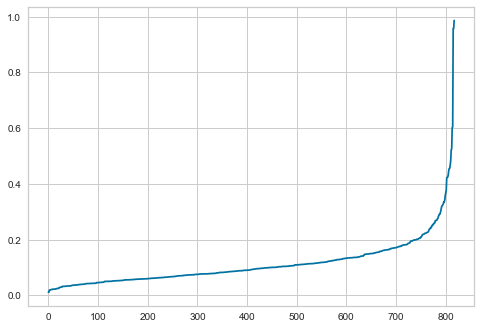

In [159]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(p=1)
nbrs = neigh.fit(minmax)
distances, indices = nbrs.kneighbors(minmax)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [201]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.2, min_samples=5)
dbs = dbs.fit(minmax)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 9 clusters


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([ 35, 235, 241,  86,  71,  33,  53,  47,  17], dtype=int64))

In [202]:
results_evaluation(dbs,minmax)

CLUSTERING DIVISION:
  1    241
 0    235
 2     86
 3     71
 5     53
 6     47
-1     35
 4     33
 7     17
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,622097.99,74555.75,15.19,69.15,84.22,1.57,438.48,0.69,59.21,0.24,1.14
0,143954.29,9130.16,7.88,82.37,96.00,1.70,55.54,0.58,71.16,0.04,0.00
1,144670.35,9406.52,7.62,86.06,97.05,1.71,73.60,0.76,74.48,0.59,0.00
2,190381.38,15458.86,9.90,85.34,97.27,1.67,121.83,0.76,76.12,0.59,2.00
3,198318.46,12977.15,8.58,84.26,96.75,1.69,99.79,0.74,73.92,0.59,1.00
4,348772.94,29326.29,10.35,83.57,97.42,1.72,175.71,0.71,76.08,0.59,3.00
5,204201.25,16510.45,9.87,81.15,97.43,1.67,104.18,0.68,74.22,0.05,2.00
6,176230.08,21934.45,13.48,83.75,97.58,1.65,116.23,0.60,72.80,0.04,1.00
7,261611.39,22801.59,9.81,80.69,97.93,1.66,140.12,0.69,70.42,0.04,3.00


The Silhouette Score is:  0.4383504657374829
The Calinski Harabasz Score is:  559.3518431503553


- ### With Standard Scaler Data

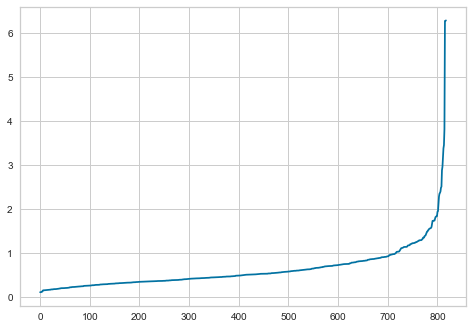

In [166]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_StandardScaler)
distances, indices = nbrs.kneighbors(groupby_domains_StandardScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [203]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1, min_samples=5)
dbs = dbs.fit(groupby_domains_StandardScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 9 clusters


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([175,  24,  82, 203, 196,  11,  62,  40,  25], dtype=int64))

In [204]:
results_evaluation(dbs, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
  2    203
 3    196
-1    175
 1     82
 5     62
 6     40
 7     25
 0     24
 4     11
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,371296.41,32359.63,10.90,78.55,92.22,1.70,206.79,0.78,66.36,0.29,0.86
0,302171.90,20111.95,7.28,85.24,97.27,1.72,146.40,0.78,75.76,0.59,3.00
1,166809.34,14200.78,9.96,85.57,97.33,1.67,107.06,0.76,76.25,0.59,2.00
2,119670.76,8643.14,8.28,83.41,96.94,1.69,53.18,0.56,72.42,0.04,0.00
3,120877.74,8125.92,7.33,86.54,97.90,1.70,57.81,0.70,76.16,0.59,0.00
4,221391.92,20106.73,10.67,82.84,98.53,1.67,120.94,0.65,72.00,0.04,3.00
5,147756.07,13173.67,9.51,84.43,97.03,1.69,100.14,0.74,74.54,0.59,1.00
6,167619.37,13045.23,9.64,81.18,97.49,1.66,84.59,0.66,75.86,0.05,2.00
7,151620.23,12685.73,9.48,84.38,97.60,1.62,53.43,0.49,73.71,0.05,1.00


The Silhouette Score is:  0.033401755430523164
The Calinski Harabasz Score is:  40.666820715295124


- ### Conclusions:

It only works well with the MINMAX transformation


## OPTICS

In [208]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=20).fit(minmax)

In [209]:
results_evaluation(optics,minmax)

CLUSTERING DIVISION:
  0    244
 3    241
 5     89
 4     72
 2     56
 1     48
 6     35
-1     33
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
-1,548245.05,59989.37,12.42,73.08,88.92,1.60,382.32,0.76,63.49,0.15,2.12
0,144341.92,9200.11,7.75,81.54,95.29,1.69,58.01,0.58,70.28,0.04,0.00
1,196965.06,22250.30,13.26,83.92,97.55,1.65,118.85,0.61,72.85,0.04,1.00
2,206865.50,21396.29,11.59,81.37,97.55,1.67,123.98,0.68,74.66,0.05,2.02
3,144832.63,9774.00,7.85,86.09,97.05,1.71,69.14,0.74,74.57,0.59,0.00
4,207510.39,14152.04,8.62,84.31,96.78,1.69,115.95,0.75,73.95,0.59,1.00
5,208608.98,16204.05,9.71,85.24,97.31,1.67,129.00,0.78,75.66,0.59,2.00
6,377774.68,35054.11,10.90,83.12,97.51,1.72,198.62,0.69,75.72,0.59,3.00


The Silhouette Score is:  0.42585122399039704
The Calinski Harabasz Score is:  656.8449604930588


## PCA + KMEANS

By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.
In the case of PCA and K-means in particular, there appears to be an even closer relationship between the two.

- **With the Robust Scaler data**

Text(0, 0.5, 'Cumulative explained variance')

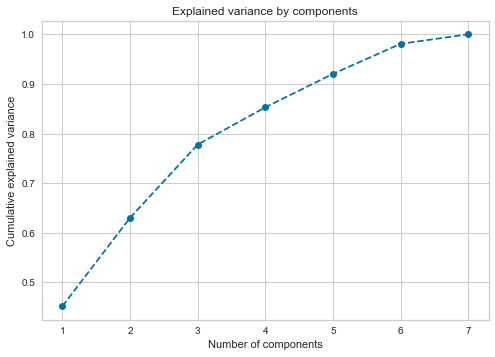

In [211]:
pca = PCA()
pca.fit(groupby_domains_RobustScaler)
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [213]:
pca_robustscaler = PCA(n_components=4)
pca_robustscaler = pca_robustscaler.fit_transform(groupby_domains_RobustScaler)

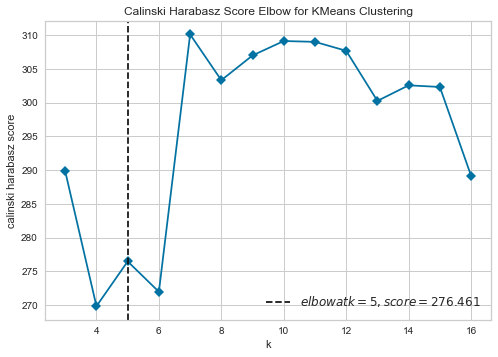

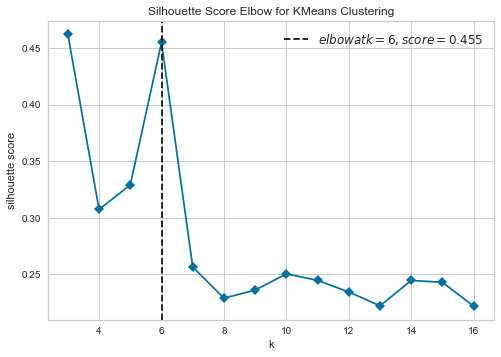

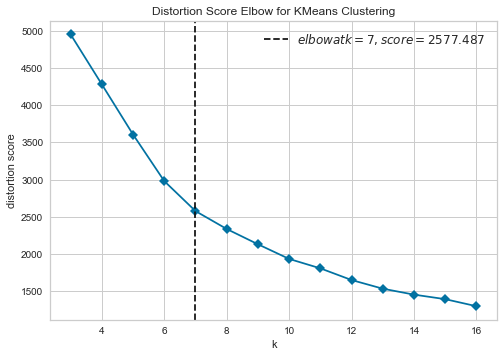

In [219]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_robustscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [228]:
kmeans_pca_robustscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_robustscaler.fit(pca_robustscaler)
results_evaluation(kmeans_pca_robustscaler, pca_robustscaler)

CLUSTERING DIVISION:
 1    653
5     81
0     55
3     16
4     10
2      3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,137264.48,4468.13,3.84,77.17,96.55,2.22,18.70,0.33,64.55,0.27,0.09
1,133556.94,11156.00,9.13,84.61,96.89,1.66,78.53,0.73,74.09,0.34,0.64
2,2473559.25,154454.72,7.57,83.18,96.59,1.64,484.58,0.34,71.62,0.40,1.00
3,663092.41,139954.58,33.27,82.61,99.17,1.74,832.05,0.56,80.35,0.38,2.31
4,113392.25,1355.62,1.80,45.37,44.25,0.46,9.20,0.25,33.80,0.14,0.00
5,519231.19,28239.63,7.36,82.51,97.09,1.68,193.81,0.66,72.03,0.39,1.48


The Silhouette Score is:  0.4549643495097672
The Calinski Harabasz Score is:  300.2527680169304


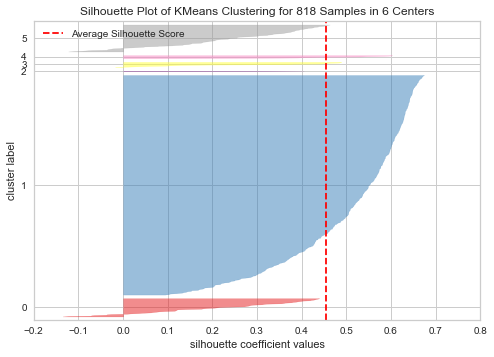

In [229]:
sv = SilhouetteVisualizer(kmeans_pca_robustscaler)
sv.fit(pca_robustscaler)
sv.show()

- **With the Standard Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

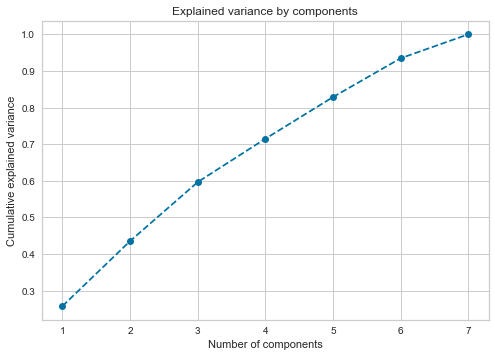

In [230]:
pca = PCA()
pca.fit(groupby_domains_StandardScaler)
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [232]:
pca_standardscaler = PCA(n_components=5)
pca_standardscaler = pca_standardscaler.fit_transform(groupby_domains_StandardScaler)

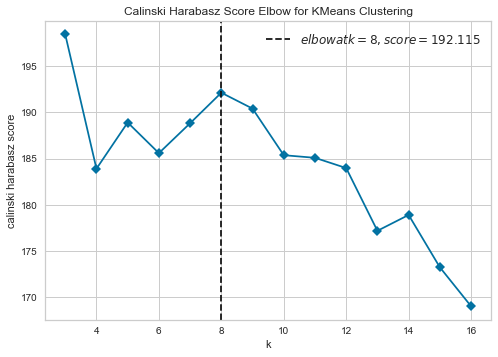

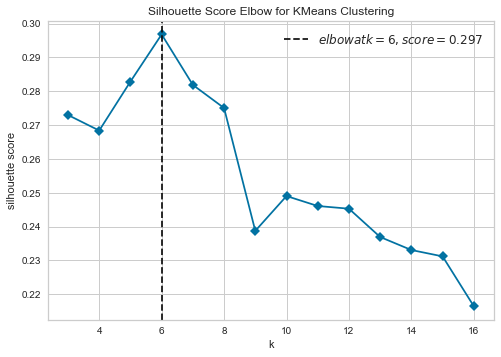

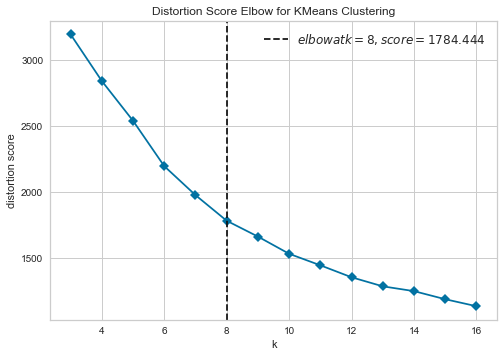

In [235]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_standardscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [236]:
kmeans_pca_standardscaler = KMeans(n_clusters=8, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_robustscaler.fit(pca_standardscaler)
results_evaluation(kmeans_pca_robustscaler, pca_standardscaler)

CLUSTERING DIVISION:
 1    357
3    308
5     70
2     33
4     29
0     21
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,127366.70,1309.18,1.16,48.11,62.76,1.13,4.93,0.16,30.08,0.19,0.00
1,180511.85,13110.86,8.83,85.28,97.45,1.69,86.70,0.65,75.80,0.58,0.89
2,151177.77,6483.18,5.05,81.52,97.26,2.40,18.75,0.38,70.35,0.37,0.09
3,158242.39,12587.03,9.54,82.96,96.82,1.67,69.97,0.54,72.94,0.04,0.58
4,890823.70,109342.16,20.53,81.14,97.87,1.67,662.67,0.64,76.15,0.33,2.14
5,132931.29,8063.96,6.68,87.93,96.95,1.61,148.89,1.87,70.20,0.41,0.34


The Silhouette Score is:  0.2967706214384688
The Calinski Harabasz Score is:  188.26565868732916


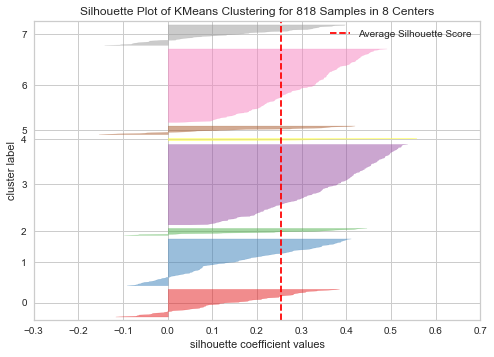

In [237]:
sv = SilhouetteVisualizer(kmeans_pca_standardscaler)
sv.fit(pca_standardscaler)
sv.show()

- **With the Minmax Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

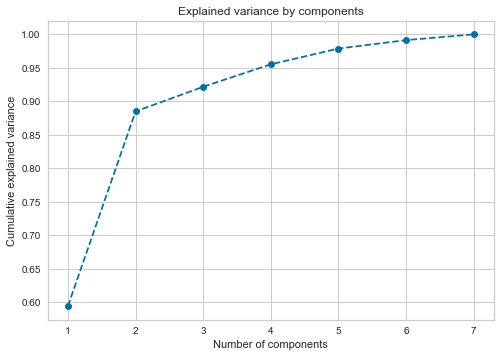

In [238]:
pca = PCA()
pca.fit(minmax)
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [239]:
pca_minmax = PCA(n_components=2)
pca_minmax = pca_minmax.fit_transform(minmax)

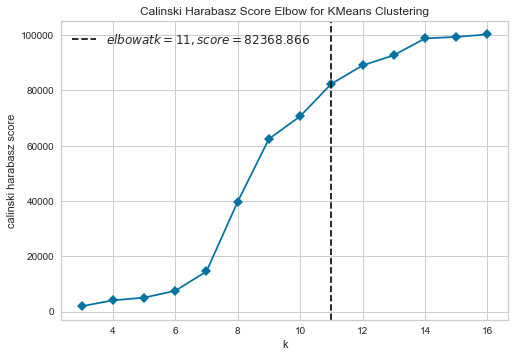

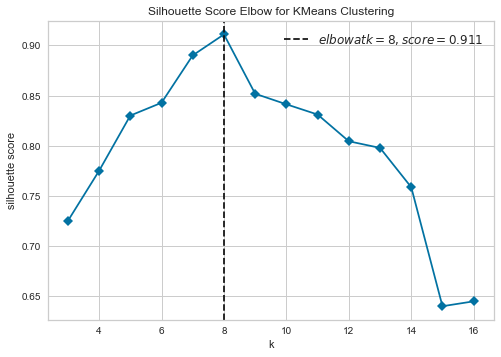

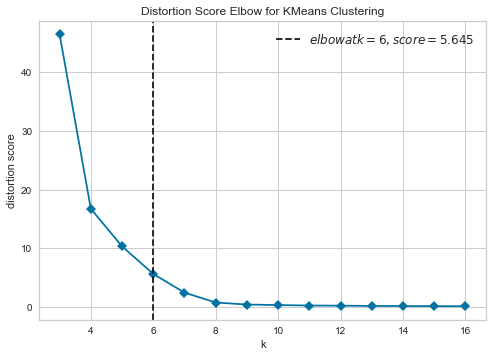

In [243]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [244]:
kmeans_pca_minmax = KMeans(n_clusters=8, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 2    250
1    242
3     89
4     75
0     55
5     49
6     38
7     20
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,208830.80,21456.63,11.47,81.20,97.52,1.67,123.43,0.67,74.54,0.05,2
1,144678.00,9841.29,7.91,86.09,97.06,1.71,73.31,0.76,74.57,0.59,0
2,148189.36,9141.59,7.59,80.63,94.15,1.67,57.27,0.59,69.30,0.04,0
3,208608.98,16204.05,9.71,85.24,97.31,1.67,129.00,0.78,75.66,0.59,2
4,261934.27,19666.20,8.59,83.71,96.86,1.70,130.07,0.73,73.30,0.59,1
5,251106.47,21990.44,13.00,83.91,97.43,1.65,117.42,0.61,72.73,0.04,1
6,406972.88,49323.14,12.91,83.44,97.62,1.72,357.36,0.72,75.90,0.59,3
7,322923.25,40908.85,13.20,80.04,98.10,1.68,172.35,0.62,72.46,0.04,3


The Silhouette Score is:  0.9109768528265831
The Calinski Harabasz Score is:  39744.0370422201


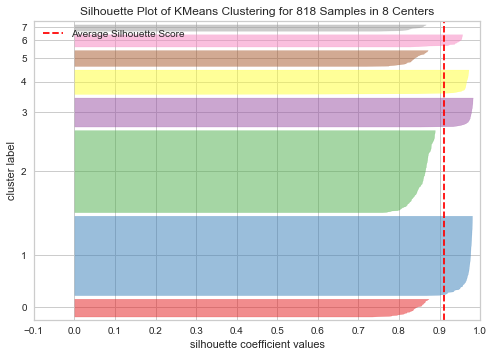

In [245]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

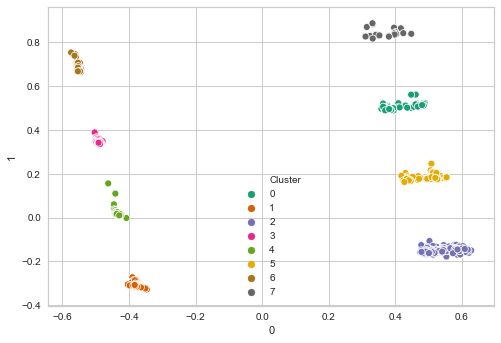

In [252]:
pca_minmax_df = pd.DataFrame(pca_minmax.copy())
pca_minmax_df['Cluster'] = kmeans_pca_minmax.labels_
sns.scatterplot(pca_minmax_df[0],pca_minmax_df[1],hue=pca_minmax_df['Cluster'], palette='Dark2')

- **With the orginal/raw Data**

Text(0, 0.5, 'Cumulative explained variance')

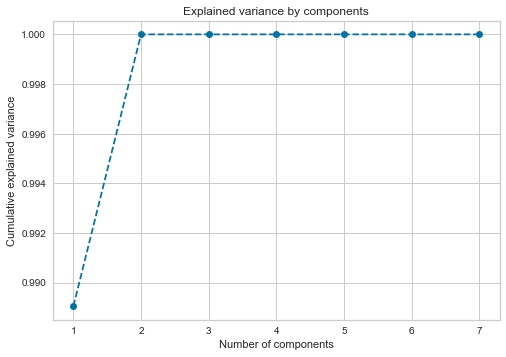

In [254]:
pca = PCA()
pca.fit(groupby_domains_clustering)
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [255]:
pca_rawdata = PCA(n_components=2)
pca_rawdata = pca_rawdata.fit_transform(groupby_domains_clustering)

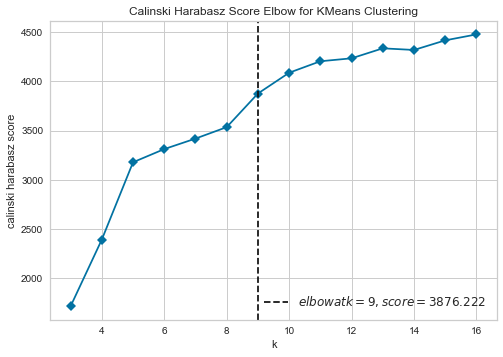

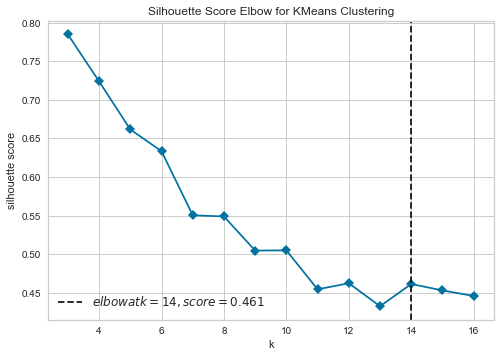

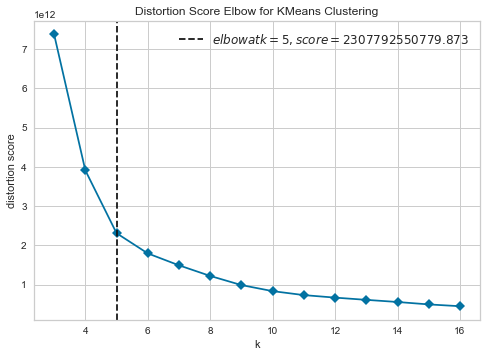

In [258]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_rawdata, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [261]:
kmeans_pca_rawdata = KMeans(n_clusters=5, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_rawdata.fit(pca_rawdata)
results_evaluation(kmeans_pca_rawdata, pca_rawdata)

CLUSTERING DIVISION:
 0    583
4    155
2     57
1     20
3      3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,108083.70,10199.25,9.33,83.76,96.30,1.69,69.21,0.69,72.98,0.33,0.48
1,910210.28,66451.42,8.39,82.20,96.22,1.66,535.76,0.69,73.59,0.34,1.35
2,496852.19,38166.88,9.42,82.66,97.49,1.69,226.23,0.66,72.75,0.40,1.49
3,2473559.25,154454.72,7.57,83.18,96.59,1.64,484.58,0.34,71.62,0.40,1.00
4,251779.21,16904.18,7.61,82.37,95.79,1.70,112.59,0.69,72.38,0.33,1.25


The Silhouette Score is:  0.6616444920252155
The Calinski Harabasz Score is:  3177.0555914756123


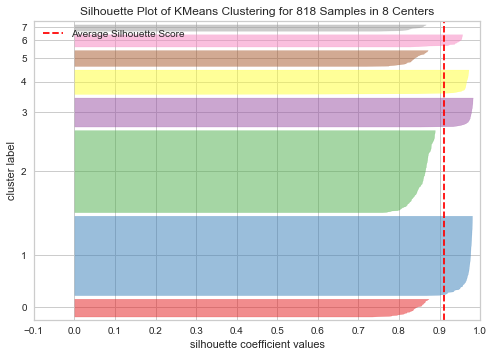

In [262]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

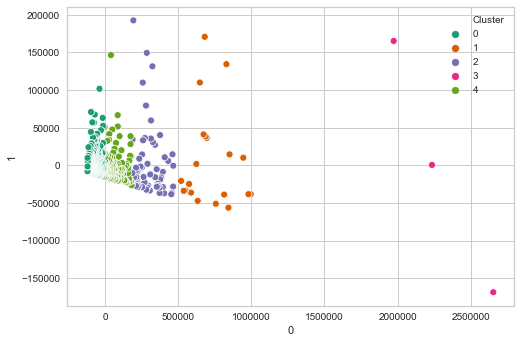

In [263]:
pca_rawdata_df = pd.DataFrame(pca_rawdata.copy())
pca_rawdata_df['Cluster'] = kmeans_pca_rawdata.labels_
sns.scatterplot(pca_rawdata_df[0],pca_rawdata_df[1],hue=pca_rawdata_df['Cluster'], palette='Dark2')

- ### Conclussions:

K-Means + PCA transformation with the Minmax Scaler data gives a significant better result than the K-Means algorithm without PCA. The Silhouette Score with 8 cluster is about 90%.

## K-MEDOIDS

- ### With the Robust Scaler Data

In [265]:
%run KMEDOIDS.py

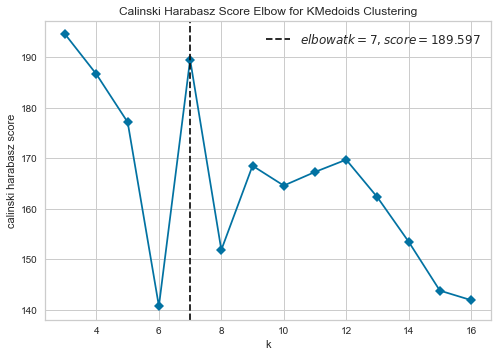

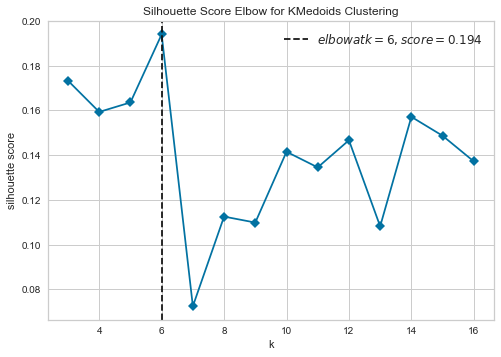

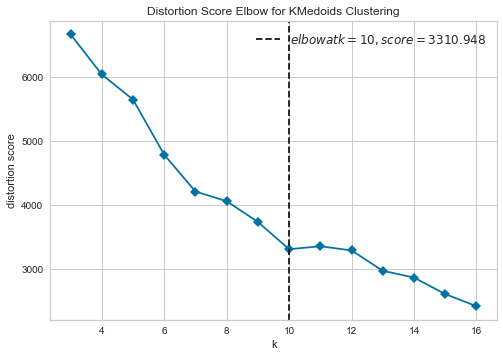

In [270]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')

visualization_clusters(groupby_domains_RobustScaler,model)

In [273]:
kmedoids_robust = KMedoids(n_clusters = 10, init= 'k-medoids++')
kmedoids_robust.fit(groupby_domains_RobustScaler)
results_evaluation(kmedoids_robust, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
 5    170
4    156
8    140
6    102
0     88
2     78
1     45
9     21
3     12
7      6
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,120530.72,4741.87,4.71,80.97,97.31,1.89,18.83,0.37,69.08,0.17,0.06
1,790438.83,36730.47,5.59,82.58,96.50,1.68,242.99,0.66,72.11,0.37,1.31
2,148081.64,36538.46,27.92,85.84,98.99,1.64,198.84,0.57,78.64,0.21,0.27
3,664237.39,173965.19,40.47,82.41,99.48,1.76,961.00,0.52,82.07,0.40,2.42
4,186745.07,17078.51,10.39,83.87,97.65,1.66,126.02,0.79,74.95,0.40,2.25
5,106162.24,5609.95,5.68,86.71,96.89,1.64,40.24,0.61,79.67,0.46,0.06
6,229389.89,11241.64,6.75,83.67,96.66,1.73,74.94,0.66,73.53,0.46,0.89
7,110383.01,1915.79,2.57,32.77,33.09,0.19,10.00,0.16,26.04,0.03,0.00
8,115592.14,4791.92,4.66,81.70,93.95,1.58,61.01,1.03,62.85,0.21,0.14


The Silhouette Score is:  0.12893265567527556
The Calinski Harabasz Score is:  132.57215591495657


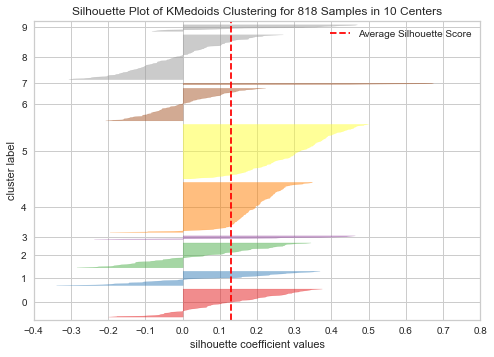

In [282]:
sv = SilhouetteVisualizer(kmedoids_robust)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the Standard Scaler Data

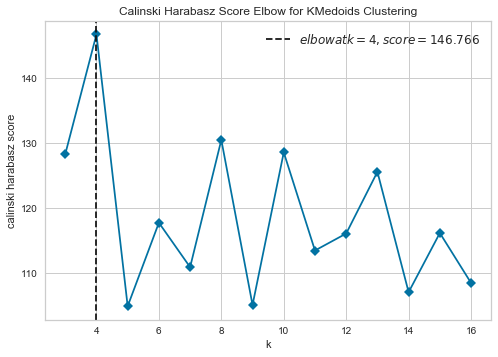

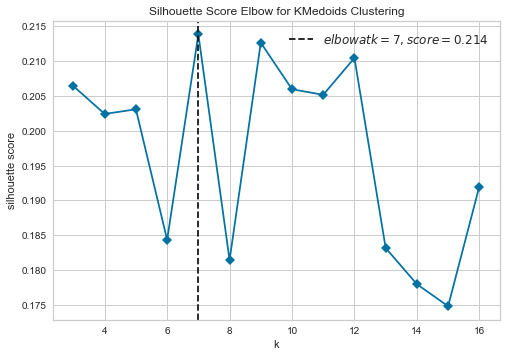

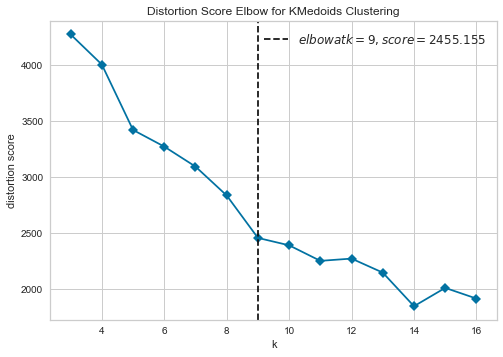

In [280]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_StandardScaler,model)

In [281]:
kmedoids_standard = KMedoids(n_clusters = 7, init= 'k-medoids++')
kmedoids_standard.fit(groupby_domains_StandardScaler)
results_evaluation(kmedoids_standard, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
 2    253
3    192
1    153
0    124
5     50
6     30
4     16
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,138763.91,9043.50,7.78,88.03,96.85,1.64,118.48,1.35,71.82,0.55,0.15
1,135760.30,10914.38,8.74,84.34,98.00,1.76,42.77,0.39,77.75,0.59,0.12
2,128519.63,11988.76,10.03,83.03,96.22,1.66,63.06,0.54,74.26,0.04,0.30
3,217182.54,16482.41,9.13,85.20,97.24,1.69,127.51,0.78,75.41,0.47,2.08
4,884969.75,155173.52,29.16,81.53,99.18,1.70,878.24,0.55,78.42,0.42,2.44
5,142394.46,2473.37,2.19,64.57,85.47,1.73,13.74,0.36,42.98,0.13,0.20
6,750407.63,31290.02,5.90,82.94,96.13,1.65,215.09,0.61,70.98,0.17,0.80


The Silhouette Score is:  0.20092685028239782
The Calinski Harabasz Score is:  125.31526632493339


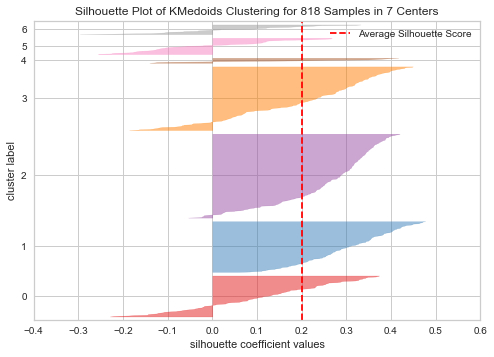

In [283]:
sv = SilhouetteVisualizer(kmedoids_standard)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the MinMax Scaler Data

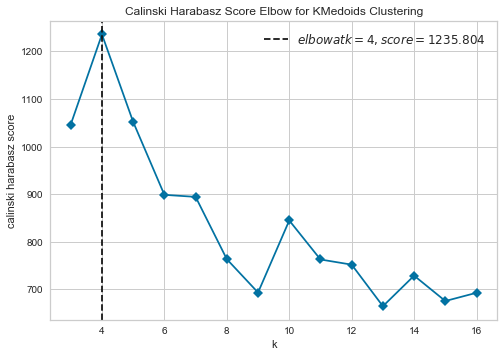

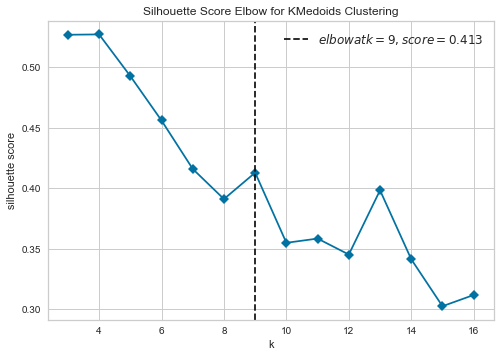

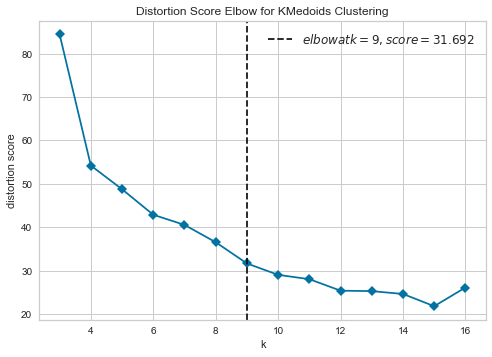

In [285]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(minmax,model)

In [290]:
kmedoids_minmax = KMedoids(n_clusters = 9, init= 'k-medoids++')
kmedoids_minmax.fit(minmax)
results_evaluation(kmedoids_minmax, minmax )

CLUSTERING DIVISION:
 5    234
2    190
0    127
4     75
7     55
8     52
3     49
6     20
1     16
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,267961.96,26113.70,10.67,84.70,97.40,1.69,197.33,0.76,75.74,0.59,2.30
1,128928.33,1584.53,1.42,41.22,62.62,1.07,4.88,0.19,27.78,0.04,0.00
2,148466.98,10376.07,8.13,85.12,96.88,1.73,54.72,0.51,74.98,0.59,0.00
3,251106.47,21990.44,13.00,83.91,97.43,1.65,117.42,0.61,72.73,0.04,1.00
4,261934.27,19666.20,8.59,83.71,96.86,1.70,130.07,0.73,73.30,0.59,1.00
5,149506.36,9658.31,8.01,83.33,96.30,1.72,60.86,0.61,72.14,0.04,0.00
6,322923.25,40908.85,13.20,80.04,98.10,1.68,172.35,0.62,72.46,0.04,3.00
7,208830.80,21456.63,11.47,81.20,97.52,1.67,123.43,0.67,74.54,0.05,2.00
8,130833.68,7887.31,7.13,89.63,97.74,1.63,141.22,1.68,73.08,0.59,0.00


The Silhouette Score is:  0.41216558878420134
The Calinski Harabasz Score is:  845.4042250087737


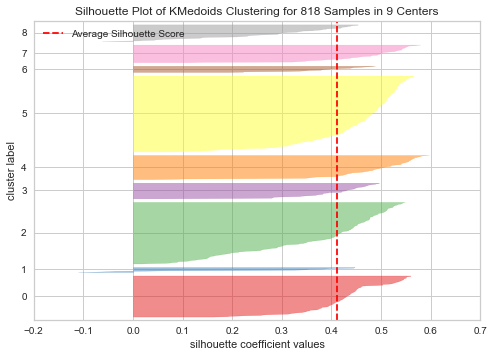

In [291]:
sv = SilhouetteVisualizer(kmedoids_minmax)
sv.fit(minmax)
sv.show()

- **With the PCA scores**

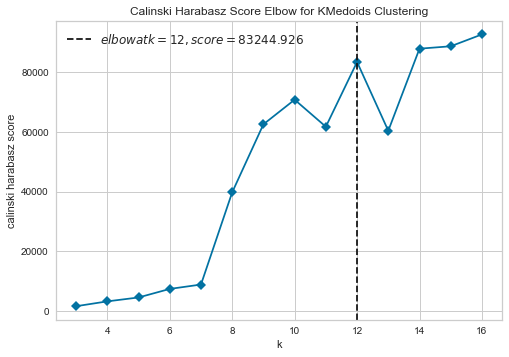

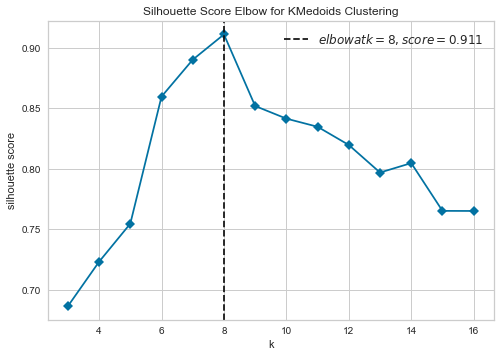

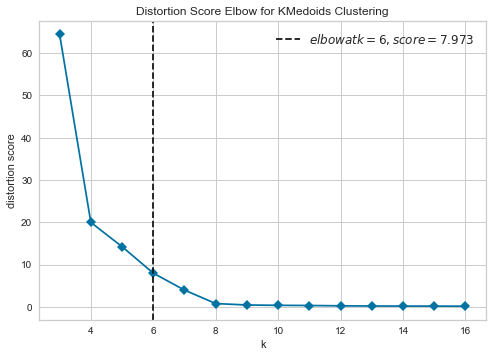

In [293]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(pca_minmax,model)

In [294]:
kmedoids_pca_minmax = KMedoids(n_clusters = 8, init= 'k-medoids++')
kmedoids_pca_minmax.fit(pca_minmax)
results_evaluation(kmedoids_pca_minmax, pca_minmax )

CLUSTERING DIVISION:
 4    250
0    242
3     89
6     75
5     55
1     49
2     38
7     20
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Domain Recurrence
Cluster,,,,,,,,,,,
0,144678.00,9841.29,7.91,86.09,97.06,1.71,73.31,0.76,74.57,0.59,0
1,251106.47,21990.44,13.00,83.91,97.43,1.65,117.42,0.61,72.73,0.04,1
2,406972.88,49323.14,12.91,83.44,97.62,1.72,357.36,0.72,75.90,0.59,3
3,208608.98,16204.05,9.71,85.24,97.31,1.67,129.00,0.78,75.66,0.59,2
4,148189.36,9141.59,7.59,80.63,94.15,1.67,57.27,0.59,69.30,0.04,0
5,208830.80,21456.63,11.47,81.20,97.52,1.67,123.43,0.67,74.54,0.05,2
6,261934.27,19666.20,8.59,83.71,96.86,1.70,130.07,0.73,73.30,0.59,1
7,322923.25,40908.85,13.20,80.04,98.10,1.68,172.35,0.62,72.46,0.04,3


The Silhouette Score is:  0.9109768528265831
The Calinski Harabasz Score is:  39744.037042220094


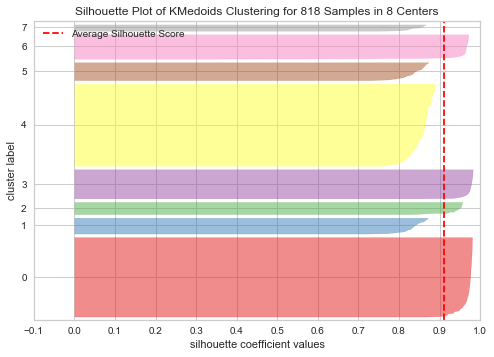

In [295]:
sv = SilhouetteVisualizer(kmedoids_pca_minmax)
sv.fit(pca_minmax)
sv.show()

### Hopkins statistic

### Visual Assessment of cluster Tendency (VAT)

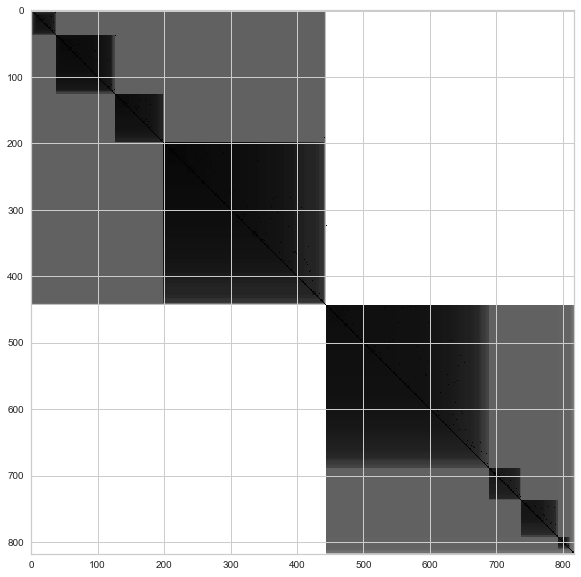

In [276]:
from pyclustertend import ivat
ivat(minmax)